In [1]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import he_normal
from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
from tqdm import tqdm

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## validation用のpattern2データ読み込み

In [2]:
pattern_file = np.load("validation_pattern2.npy")
pattern_file.shape

(28685,)

In [3]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

In [ ]:
train_Label = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_LAbel.npy")[:, 0]
Y_train = train_Label.reshape([-1])
del train_Label
Y_train.shape

In [ ]:
val_label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0]
Y_val = val_label[pattern_file == 1].reshape([-1])
del val_label
Y_val.shape

In [4]:
val_label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0]
Y_train = val_label[pattern_file == 1].reshape([-1])
del val_label
Y_train.shape

(14338,)

In [5]:
val_label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0]
Y_val = val_label[pattern_file == 0].reshape([-1])
del val_label
Y_val.shape

(5696,)

## 削除するインデックスの処理

In [6]:
train_change_index = []
for i in tqdm(range(len(Y_train)-1)):
    if Y_train[i] != Y_train[i+1]:
        train_change_index.append(i+1)
        
change_before_index = []
for i in range(len(train_change_index)):
    change_before_index.append(train_change_index[i] - 1)
    
for i in range(len(change_before_index)):
    train_change_index.append(change_before_index[i])
len(train_change_index)

100%|████████████████████████████████████████████████████████████████████████| 14337/14337 [00:00<00:00, 939721.78it/s]


106

In [7]:
Y_train = np.delete(Y_train, train_change_index, axis=0)
Y_train.shape, Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)].shape

((14232,), (10207,))

In [8]:
val_change_index = []
for i in tqdm(range(len(Y_val)-1)):
    if Y_val[i] != Y_val[i+1]:
        val_change_index.append(i+1)
        
change_before_index = []
for i in range(len(val_change_index)):
    change_before_index.append(val_change_index[i] - 1)
    
for i in range(len(change_before_index)):
    val_change_index.append(change_before_index[i])
len(val_change_index)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5695/5695 [00:00<?, ?it/s]


62

In [9]:
Y_val = np.delete(Y_val, val_change_index, axis=0)
Y_val.shape, Y_val[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)].shape

((5634,), (4037,))

In [ ]:
def load_npy(hold_position):
    mag = np.delete(np.load("../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_mag_norm_spectram_axis1_2.npy"), train_change_index, 0)#[:, :40, :]
#     mag = mag[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
    return mag

In [ ]:
train_Hips = load_npy("Hips")
# train_Hips, X_val1 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_train1 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train1 = X_train1.reshape([-1, X_train1.shape[1], X_train1.shape[2], 1])

X_train1.shape

In [ ]:
def load_npy(hold_position):
    mag = np.load("../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_mag_norm_spectram_axis1_2.npy")#[:, :40, :]
    return mag

train_Hips = np.delete(load_npy("Hips")[pattern_file == 1], val_change_index, axis=0)

X_val1 = train_Hips[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)]
X_val1 = X_val1.reshape([-1, X_val1.shape[1], X_val1.shape[2], 1])

X_val1.shape

In [10]:
def load_npy(hold_position):
    mag = np.load("../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_mag_norm_spectram_axis1_2.npy")#[:, :40, :]
    return mag

train_Hips = np.delete(load_npy("Hips")[pattern_file == 1], train_change_index, axis=0)
X_train1 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train1 = X_train1.reshape([-1, X_train1.shape[1], X_train1.shape[2], 1])

train_Hips = np.delete(load_npy("Hips")[pattern_file == 0], val_change_index, axis=0)
X_val1 = train_Hips[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)]
X_val1 = X_val1.reshape([-1, X_val1.shape[1], X_val1.shape[2], 1])

X_train1.shape, X_val1.shape

((10207, 41, 43, 1), (4037, 41, 43, 1))

In [11]:
del train_Hips

In [ ]:
train_Bag = load_npy("Bag")
train_Hips = load_npy("Hips")
train_Torso = load_npy("Torso")
train_Hand = load_npy("Hand")

train_Hand.shape

In [ ]:
# train_Hips, X_val1 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_val1 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_val1 = X_val1.reshape([-1, X_val1.shape[1], X_val1.shape[2], 1])

X_val1.shape

In [ ]:
X_train1 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train1.shape

In [ ]:
# X_train1 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hips, \
#                           train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)

X_train1 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)
X_train1.shape

In [ ]:
del train_Bag, train_Hips, train_Torso, train_Hand

In [ ]:
X_train1 = X_train1.reshape([-1, X_train1.shape[1], X_train1.shape[2], 1])

X_train1.shape

In [ ]:
def load_npy(hold_position):
    lacc = np.delete(np.load("../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_lacc_norm_spectram_axis1_2.npy"), train_change_index, 0)#[:, :64, :]
#     lacc = lacc[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
    return lacc

In [ ]:
train_Hips = load_npy("Hips")
# train_Hips, X_val1 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_train2 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train2 = X_train2.reshape([-1, X_train2.shape[1], X_train2.shape[2], 1])

X_train2.shape

In [13]:
def load_npy(hold_position):
    lacc = np.load("../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_lacc_norm_spectram_axis1_2.npy")#[:, :64, :]
#     lacc = lacc[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
    return lacc

train_Hips = np.delete(load_npy("Hips")[pattern_file == 1], train_change_index, axis=0)
X_train2 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train2 = X_train2.reshape([-1, X_train2.shape[1], X_train2.shape[2], 1])

train_Hips = np.delete(load_npy("Hips")[pattern_file == 0], val_change_index, axis=0)
X_val2 = train_Hips[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)]
X_val2 = X_val2.reshape([-1, X_val2.shape[1], X_val2.shape[2], 1])

X_train2.shape, X_val2.shape

((10207, 41, 43, 1), (4037, 41, 43, 1))

In [14]:
del train_Hips

In [ ]:
train_Bag = load_npy("Bag")
train_Hips = load_npy("Hips")
train_Torso = load_npy("Torso")
train_Hand = load_npy("Hand")

train_Hand.shape

In [ ]:
# train_Hips, X_val2 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_val2 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_val2 = X_val2.reshape([-1, X_val2.shape[1], X_val2.shape[2], 1])

X_val2.shape

In [ ]:
# X_train2 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hips, \
#                           train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)

X_train2 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)
X_train2.shape

In [ ]:
del train_Bag, train_Hips, train_Torso, train_Hand

In [ ]:
X_train2 = X_train2.reshape([-1, X_train2.shape[1], X_train2.shape[2], 1])

X_train2.shape

In [ ]:
def load_npy(hold_position):
    gyr = np.delete(np.load("../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_gyr_norm_spectram_axis1_2.npy"), train_change_index, 0)#[:, :64, :]
#     gyr = gyr[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
    return gyr

In [ ]:
train_Hips = load_npy("Hips")
# train_Hips, X_val1 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_train3 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train3 = X_train3.reshape([-1, X_train3.shape[1], X_train3.shape[2], 1])

X_train3.shape

In [16]:
def load_npy(hold_position):
    gyr = np.load("../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_gyr_norm_spectram_axis1_2.npy")#[:, :64, :]
#     gyr = gyr[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
    return gyr

train_Hips = np.delete(load_npy("Hips")[pattern_file == 1], train_change_index, axis=0)
X_train3 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_train3 = X_train3.reshape([-1, X_train3.shape[1], X_train3.shape[2], 1])

train_Hips = np.delete(load_npy("Hips")[pattern_file == 0], val_change_index, axis=0)
X_val3 = train_Hips[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)]
X_val3 = X_val3.reshape([-1, X_val3.shape[1], X_val3.shape[2], 1])

X_train3.shape, X_val3.shape

((10207, 41, 43, 1), (4037, 41, 43, 1))

In [17]:
del train_Hips

In [ ]:
train_Bag = load_npy("Bag")
train_Hips = load_npy("Hips")
train_Torso = load_npy("Torso")
train_Hand = load_npy("Hand")

train_Hand.shape

In [ ]:
# train_Hips, X_val3 = train_test_split(train_Hips, test_size=0.2, shuffle=False)
X_val3 = train_Hips[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
X_val3 = X_val3.reshape([-1, X_val3.shape[1], X_val3.shape[2], 1])

X_val3.shape

In [ ]:
# X_train3 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hips, \
#                           train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)

X_train3 = np.concatenate([train_Bag[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Torso[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          train_Hand[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)
X_train3.shape

In [ ]:
del train_Bag, train_Hips, train_Torso, train_Hand

In [ ]:
X_train3 = X_train3.reshape([-1, X_train3.shape[1], X_train3.shape[2], 1])

X_train3.shape

In [ ]:
# Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0).reshape([-1, 1])
# Y_train.shape

In [ ]:
# Y_train = Y_train[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 4)]
# Y_train.shape

In [ ]:
Y_train[Y_train == 1].shape, Y_train[Y_train == 5].shape, Y_train[Y_train == 6].shape, Y_train[Y_train == 7].shape, Y_train[Y_train == 8].shape

In [ ]:
# y_train, Y_val = train_test_split(Y_train, test_size=0.2, shuffle=False)
# print(Y_train.shape, y_train.shape, Y_val.shape)

Y_val = Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]

# Y_train = np.concatenate([Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
#                           y_train, \
#                           Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)], \
#                           Y_train[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)

Y_train = np.concatenate([Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)],\
                          Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)], \
                          Y_train[(Y_train == 1) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]], axis=0)

Y_train.shape, Y_val.shape

In [18]:
Y_train = Y_train[(Y_train == 1) | (Y_train == 5) | (Y_train == 6) | (Y_train == 7) | (Y_train == 8)]
Y_train.shape

(10207,)

In [19]:
Y_val = Y_val[(Y_val == 1) | (Y_val == 5) | (Y_val == 6) | (Y_val == 7) | (Y_val == 8)]
Y_val.shape

(4037,)

In [20]:
# Y_train[Y_train.reshape([-1]) == 1] = 0
# Y_train[Y_train.reshape([-1]) >= 4] = Y_train[Y_train.reshape([-1]) >= 4] - 3

Y_train = Y_train - 1
Y_train[Y_train >= 4] -= 3
np.unique(Y_train)

array([0., 1., 2., 3., 4.])

In [21]:
Y_val = Y_val - 1
Y_val[Y_val >= 4] -= 3
np.unique(Y_val)

array([0., 1., 2., 3., 4.])

In [ ]:
# x_train1, x_test1, y_train, y_test = train_test_split(X_train1, Y_train, test_size=0.3, shuffle=False)
# del X_train1, Y_train

# x_train2, x_test2 = train_test_split(X_train2, test_size=0.3, shuffle=False)
# del X_train2

# x_train3, x_test3 = train_test_split(X_train3, test_size=0.3, shuffle=False)
# del X_train3

# x_train1.shape, x_test1.shape

In [ ]:
def BuildModel(input_shape):
    input1 = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_initializer=he_normal())(input1)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = models.Model(inputs=input1, outputs=x)
    return x

In [ ]:
def BuildModel2(input_shape):
    input1 = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_initializer=he_normal())(input1)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 1))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = models.Model(inputs=input1, outputs=x)
    return x

In [ ]:
x1 = BuildModel2(X_train1[0].shape)
x2 = BuildModel2(X_train2[0].shape)
x3 = BuildModel2(X_train3[0].shape)

combined = layers.concatenate([x1.output, x2.output, x3.output])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(16, activation='relu')(z)
z = layers.Dense(5, activation='softmax')(z)

model = models.Model(inputs=[x1.input, x2.input, x3.input], outputs=z)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
class_weights = [1.304315629242605,
 1.299237767396115,
 3.763086053412463,
 1.3542930371636053,
 1.0,
 1.1219080646873563,
 1.0162841389921784,
 1.3327728266352783]

In [ ]:
X_train1, X_val1 = train_test_split(X_val1, test_size=0.3, shuffle=False)
X_train2, X_val2 = train_test_split(X_val2, test_size=0.3, shuffle=False)
X_train3, X_val3 = train_test_split(X_val3, test_size=0.3, shuffle=False)
Y_train, Y_val = train_test_split(Y_val, test_size=0.3, shuffle=False)

X_train1.shape, X_train2.shape, X_train3.shape, X_val1.shape, X_val2.shape, X_val3.shape, Y_train.shape, Y_val.shape

In [ ]:
# model = tf.keras.models.load_model("../Output/CheckPoint/mag_norm/model0603_19-0.84-0.66-1.05-0.58.hdf5")
# model.summary()

In [ ]:
model = tf.keras.Sequential()
# model.add(layers.Flatten())
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(X_train1.shape[1], X_train1.shape[2], 1), kernel_initializer=he_normal()))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath="../Output/CheckPoint/mag_norm/model0605_{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5", 
                                           monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
history = model.fit(X_train1, Y_train, epochs=256, batch_size=512, validation_data=(X_val1, Y_val), callbacks=[cp_cb, es_cb])

In [22]:
model = tf.keras.models.load_model("../Output/CheckPoint/axis1/model06082_02-1.16-0.51-1.30-0.47.hdf5")

In [23]:
import os
if not os.path.exists("../Output/CheckPoint/axis1/"):
    os.makedirs("../Output/CheckPoint/axis1/")
    
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath="../Output/CheckPoint/axis1/model06083_{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5", 
                                           monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
history = model.fit([X_train1, X_train2, X_train3], Y_train, epochs=256, batch_size=256, validation_data=([X_val1, X_val2, X_val3], Y_val), callbacks=[cp_cb, es_cb])

Train on 10207 samples, validate on 4037 samples
Epoch 1/256
10207/10207 [==============================] - 9s 912us/sample - loss: 1.1268 - accuracy: 0.5547 - val_loss: 1.3685 - val_accuracy: 0.4516ss: 1.2189 - ac - ETA: 3s
Epoch 2/256
10207/10207 [==============================] - 4s 422us/sample - loss: 0.9635 - accuracy: 0.6371 - val_loss: 1.9188 - val_accuracy: 0.3515
Epoch 3/256
10207/10207 [==============================] - 4s 425us/sample - loss: 0.8927 - accuracy: 0.6611 - val_loss: 1.4309 - val_accuracy: 0.4667
Epoch 4/256
10207/10207 [==============================] - 4s 424us/sample - loss: 0.8206 - accuracy: 0.6919 - val_loss: 1.3929 - val_accuracy: 0.4736
Epoch 5/256
10207/10207 [==============================] - 4s 425us/sample - loss: 0.7827 - accuracy: 0.7051 - val_loss: 1.4853 - val_accuracy: 0.5043
Epoch 6/256
10207/10207 [==============================] - 4s 425us/sample - loss: 0.7224 - accuracy: 0.7327 - val_loss: 1.5420 - val_accuracy: 0.4607 ETA: 1s
Epoch 7/256


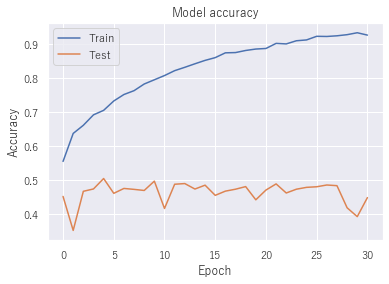

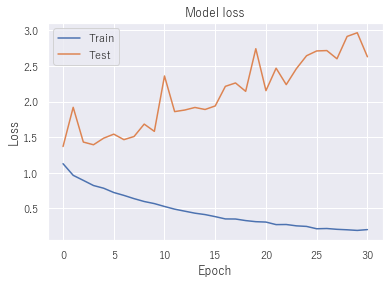

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim((0, 3.5))
plt.show()

In [25]:
model = tf.keras.models.load_model("../Output/CheckPoint/axis1/model06083_01-1.13-0.55-1.37-0.45.hdf5")

(10207,)


0.543

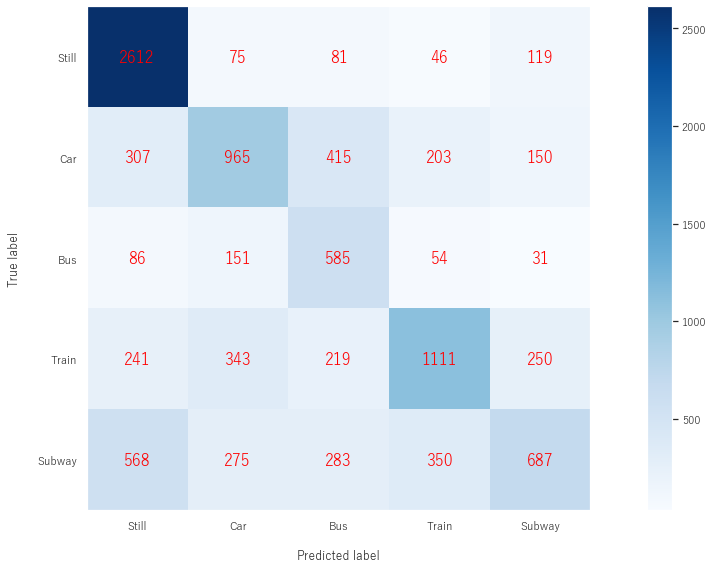

In [29]:
# class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
class_names = ["Still", "Car", "Bus", "Train", "Subway"]
predict = np.argmax(model.predict([X_train1, X_train2, X_train3]), axis=1)
print(predict.shape)
plot_confusion_matrix(Y_train, predict, class_names, False, (16, 8))
plt.grid(False)
f1_macro = f1_score(Y_train, predict, average='macro')
round(f1_macro, 3)

(4037,)


0.421

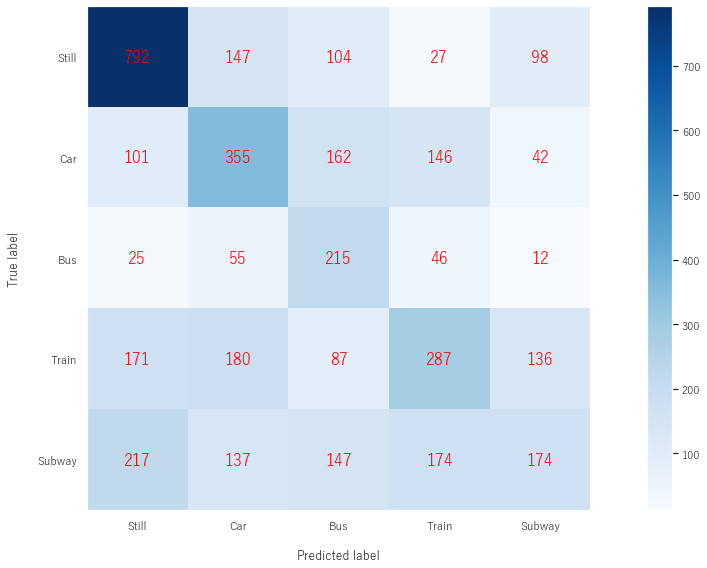

In [26]:
# class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
class_names = ["Still", "Car", "Bus", "Train", "Subway"]
predict = np.argmax(model.predict([X_val1, X_val2, X_val3]), axis=1)
print(predict.shape)
plot_confusion_matrix(Y_val, predict, class_names, False, (16, 8))
plt.grid(False)
f1_macro = f1_score(Y_val, predict, average='macro')
round(f1_macro, 3)

In [ ]:
model = tf.keras.models.load_model("../Output/CheckPoint/mag_norm/model0528_07-0.87-0.67-1.54-0.45.hdf5")

In [ ]:
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
# class_names = ["Still", "Car", "Bus", "Train", "Subway"]
predict = np.argmax(model.predict([x_test1, x_test2, x_test3]), axis=1)
print(predict.shape)
plot_confusion_matrix(y_test, predict, class_names, False, (16, 8))
plt.grid(False)
f1_macro = f1_score(y_test, predict, average='macro')
round(f1_macro, 3)

In [30]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [31]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import he_normal
from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import pandas as pd
import pickle

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [32]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

In [33]:
def load_npy(kind, hold_position):
    file_path = "../Output/" + kind + "/" + kind + "_" + hold_position + "/" + kind + "_" + hold_position + "_"
    mag = np.load(file_path + "glo_mag_norm_spectram_axis1_2.npy")#[:, :40]
    lacc = np.load(file_path + "glo_lacc_norm_spectram_axis1_2.npy")#[:, :64]
    gyr = np.load(file_path + "glo_gyr_norm_spectram_axis1_2.npy")#[:, :64]
    mag = mag.reshape([-1, mag.shape[1], mag.shape[2], 1])
    lacc = lacc.reshape([-1, lacc.shape[1], lacc.shape[2], 1])
    gyr = gyr.reshape([-1, gyr.shape[1], gyr.shape[2], 1])
    return mag, lacc, gyr

In [34]:
def predict_func(x1, x2, x3):
    model = tf.keras.models.load_model("../Output/CheckPoint/axis1/model06083_01-1.13-0.55-1.37-0.45.hdf5")
    predict = np.argmax(model.predict([x1, x2, x3]), axis=1)
    return predict

In [35]:
def save_npy(kind, hold_position, x):
    np.save(kind + "_" + hold_position + "_spectram_predict_0608", x)

In [36]:
def flow(kind, hold_position):
    label = np.load("../Data/センサ別npyファイル/" + kind + "/" + kind + "_Bag/" + kind + "_Bag_Label.npy")[:, 0].reshape([-1])
    x1, x2, x3 = load_npy(kind, hold_position)
    predict = predict_func(x1, x2, x3)
    save_npy(kind, hold_position, predict.reshape([-1, 1]))

In [37]:
kinds = ["train", "validation"]
hold_positions = ["Bag", "Hips", "Torso", "Hand"]

i = 0
for kind in kinds:
    for hold_position in tqdm(hold_positions):
#         i += 1
#         if i == 1:
#             continue
        flow(kind, hold_position)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:12<00:00, 18.08s/it]
